In [1]:
# Install Dependencies
#!pip install scenedetect[opencv,progress_bar]

In [2]:
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import cv2

from google_auth_oauthlib.flow import InstalledAppFlow
from apiclient.discovery import build
from apiclient.http import MediaFileUpload, MediaIoBaseDownload
from apiclient import errors

yt_url_prefix = 'https://www.youtube.com/watch?v='
output_folder = 'data/'

In [3]:
# GOOGLE DRIVE API CONSTANTS
flow = InstalledAppFlow.from_client_secrets_file('../credentials.json', ['https://www.googleapis.com/auth/drive'])
creds = flow.run_local_server(port=0)
folder_id = '1UnDIe4VHMM8bZzIfKEG8NJdQGnNrrxEG'
drive_api = build('drive', 'v3', credentials=creds)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=786879558582-eh0bho168rp2k1qord3av8r5u10q64sl.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A62732%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=pkide00qrMPEhb69jYC0wtyHp8jamR&access_type=offline


In [4]:
# Helpful function
def get_file_list_from_folder(service, folder_id):
    """Print files belonging to a folder.

    Args:
    service: Drive API service instance.
    folder_id: ID of the folder to print files from.
    """
    kwargs = {
        "q": "'{}' in parents".format(folder_id)
    }
    request = service.files().list(**kwargs)
    files = []
    while request is not None:
        response = request.execute()
        # Do stuff with response['files']
        files.extend(response['files'])
        request = service.files().list_next(request, response)
    return files

def download_file(service, file_id, out_file_dir):
    with open(out_file_dir, 'wb') as fo:
        a = service.files().get_media(fileId=file_id).execute()
        fo.write(a)


In [5]:
uploaded = get_file_list_from_folder(drive_api, folder_id)

# Histogram over time analysis

In [118]:
# histogram similarity metrics
def norm_hist(H):
    return H / H.size

def hist_correlation(H1, H2):
    H1, H2 = norm_hist(H1), norm_hist(H2)
    H1_bar = H1.mean()
    H2_bar = H2.mean()
    num = ((H1 - H1_bar)*(H2 - H2_bar)).sum()
    denom = ((H1 - H1_bar)**2).sum() * ((H2 - H2_bar)**2).sum()
    denom = denom ** 0.5
    return num / denom

def hist_intersection(H1, H2):
    H1, H2 = norm_hist(H1), norm_hist(H2)
    return np.minimum(H1, H2).sum()  

def hist_bhattacharyya(H1, H2):
    H1, H2 = norm_hist(H1), norm_hist(H2)
    return -np.log(np.sqrt(H1*H2).sum())

In [162]:
def collect_video_stats(video_file_name):
    vid = cv2.VideoCapture(video_file_name)
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    yt_id = video_file_name.split(".")[0]
    
    i = 0
    H_prev = None
    
    data = {
        'correlation': [],
        'intersection': [],
        'bhattacharyya': []
    }
    #vid_rgb_hist = cv2.VideoWriter(f"{yt_id}_rgb.avi", cv2.VideoWriter_fourcc(*"X264"), 23.98, (1000, 1000))
    vid_gb_hist = cv2.VideoWriter(f"{yt_id}_gb.avi", cv2.VideoWriter_fourcc(*"X264"), 23.98, (255, 255))
    #vid_rb_hist = cv2.VideoWriter(f"{yt_id}_rb.avi", cv2.VideoWriter_fourcc(*"X264"), 23.98, (255, 255))
    #vid_rg_hist = cv2.VideoWriter(f"{yt_id}_rg.avi", cv2.VideoWriter_fourcc(*"X264"), 23.98, (255, 255))
    

    while True:
        # Read image and make histogram
        success, image = vid.read()

        # Break if no more frames left
        if not success or i > 2:
            break

        # Print status update if there are more frames to process
        print(f"Processing Frame {i}/{frame_count}", end="\r")    

        # Make Histograms
        flat = image.reshape(-1, image.shape[-1])
        H, _ = np.histogramdd(flat, bins=(255, 255, 255))
        gb = np.sum(H, axis = 0)
        rb = np.sum(H, axis = 1)
        rg = np.sum(H, axis = 2)
        
        # RGB Histogram
        nz = H.nonzero()
        xs, ys, zs = nz
        c = np.array(nz).T / 255
        s = H[nz]
        s = np.log(s) * 10
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111, projection='3d')
        _ = ax.scatter(
            xs = xs,
            ys = ys,
            zs = zs,
            s = s,
            c = c
        )
        ax.set_xlabel('R', fontsize=20)
        ax.set_ylabel('G', fontsize=20)
        ax.set_zlabel('B', fontsize=20)
        fig.savefig('hist_rgb.png', dpi = 50)
        hist_rgb = cv2.imread('hist_rgb.png').astype('uint8')
        print(hist_rgb.shape)
        #vid_rgb_hist.write(hist_rgb)
        #os.remove('hist_rgb.png')
        plt.close('all')
        
        
        # GB Histogram
        gb = np.log(gb+1)
        gb = np.flip(gb, 0)
        gb_hist_frame = np.stack([gb, gb, gb], axis=2)
        gb_hist_frame = gb_hist_frame * 255 / gb_hist_frame.max()
        gb_hist_frame = gb_hist_frame.astype('uint8')
        print(gb_hist_frame.shape)
        print(gb_hist_frame.dtype)
        print(gb_hist_frame.max())
        vid_gb_hist.write(gb_hist_frame)
        cv2.imwrite("gb_hist_frame.png", gb_hist_frame)
        
        # RB Histogram
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111)
        _ = ax.imshow(np.log(rb+1))
        ax.set_xlabel('R', fontsize=20)
        ax.set_ylabel('B', fontsize=20)
        ax.invert_yaxis()
        fig.savefig('hist_rb.png', dpi = 50)
        #vid_rb_hist.write(cv2.imread('hist_rb.png').astype('uint8'))
        #os.remove('hist_rb.png')
        plt.close('all')
        
        # RG Histogram
        fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111)
        _ = ax.imshow(np.log(rg+1))
        ax.set_xlabel('R', fontsize=20)
        ax.set_ylabel('G', fontsize=20)
        ax.invert_yaxis()
        fig.savefig('hist_rg.png', dpi = 50)
        #vid_rg_hist.write(cv2.imread('hist_rg.png').astype('uint8'))
        #os.remove('hist_rg.png')
        plt.close('all')

        # Collect Stats
        if H_prev is not None:
            data['correlation'].append(hist_correlation(H, H_prev))
            data['intersection'].append(hist_intersection(H, H_prev))
            data['bhattacharyya'].append(hist_bhattacharyya(H, H_prev))

        # Increment
        H_prev = H
        i += 1
    
    # Close video streams
    vid_rgb_hist.release()
    vid_gb_hist.release()
    vid_rb_hist.release()
    vid_rg_hist.release()
    
    # Make DataFrame
    return pd.DataFrame(data)

In [ ]:
for file in uploaded[:1]:
    print(f"Processing Video {file['name']}")
    download_file(drive_api, file['id'], file['name'])
    stats = collect_video_stats(file['name'])
    stats.to_csv(file['name'].split('.')[0] + ".csv")
    os.remove(file['name'])

Processing Video BN4p7XhR16A.mp4
(1000, 1000, 3)e 0/1718
(255, 255, 3)
uint8
255
(1000, 1000, 3)e 1/1718
(255, 255, 3)
uint8
255


In [ ]:
plt.plot(stats.index, stats['correlation'])
plt.show()

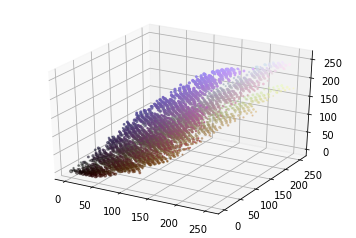

In [33]:
download_file(drive_api, uploaded[0]['id'], uploaded[0]['name'])
vid = cv2.VideoCapture(uploaded[0]['name'])
hist_vid = cv2.VideoWriter("channel1.mp4", cv2.VideoWriter_fourcc(*"X264"), 23.98, (1920, 1080))
success, image = vid.read()

In [59]:
# Make RGB Histogram
flat = image.reshape(-1, image.shape[-1])
H, _ = np.histogramdd(flat, bins=(255, 255, 255))

In [85]:
nz = H.nonzero()
xs, ys, zs = nz
c = np.array(nz).T / 255
s = H[nz]
s = np.log(s) * 10

In [86]:
gb = np.sum(H, axis = 0)
rb = np.sum(H, axis = 1)
rg = np.sum(H, axis = 2)

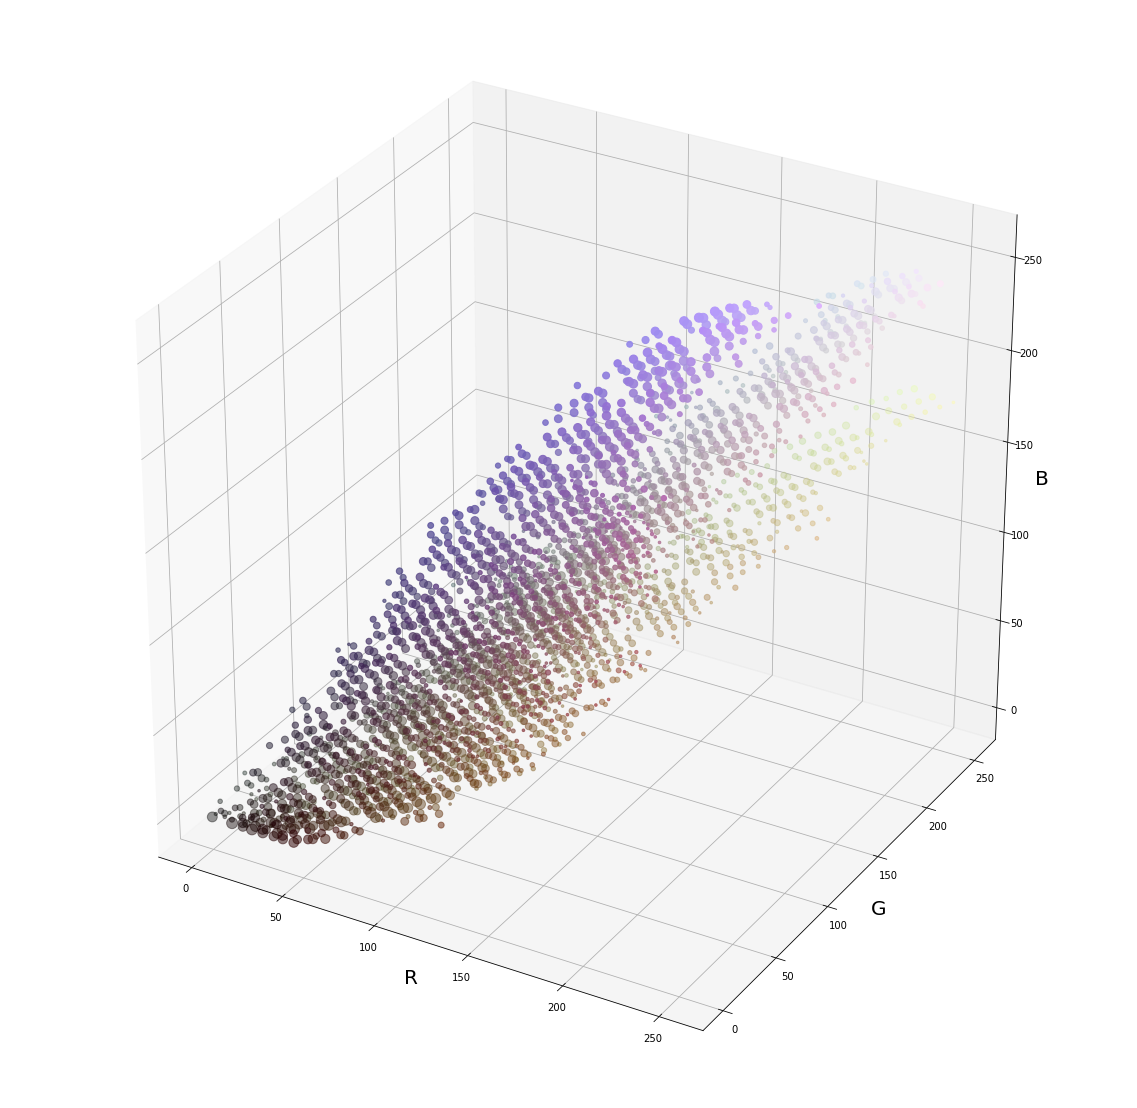

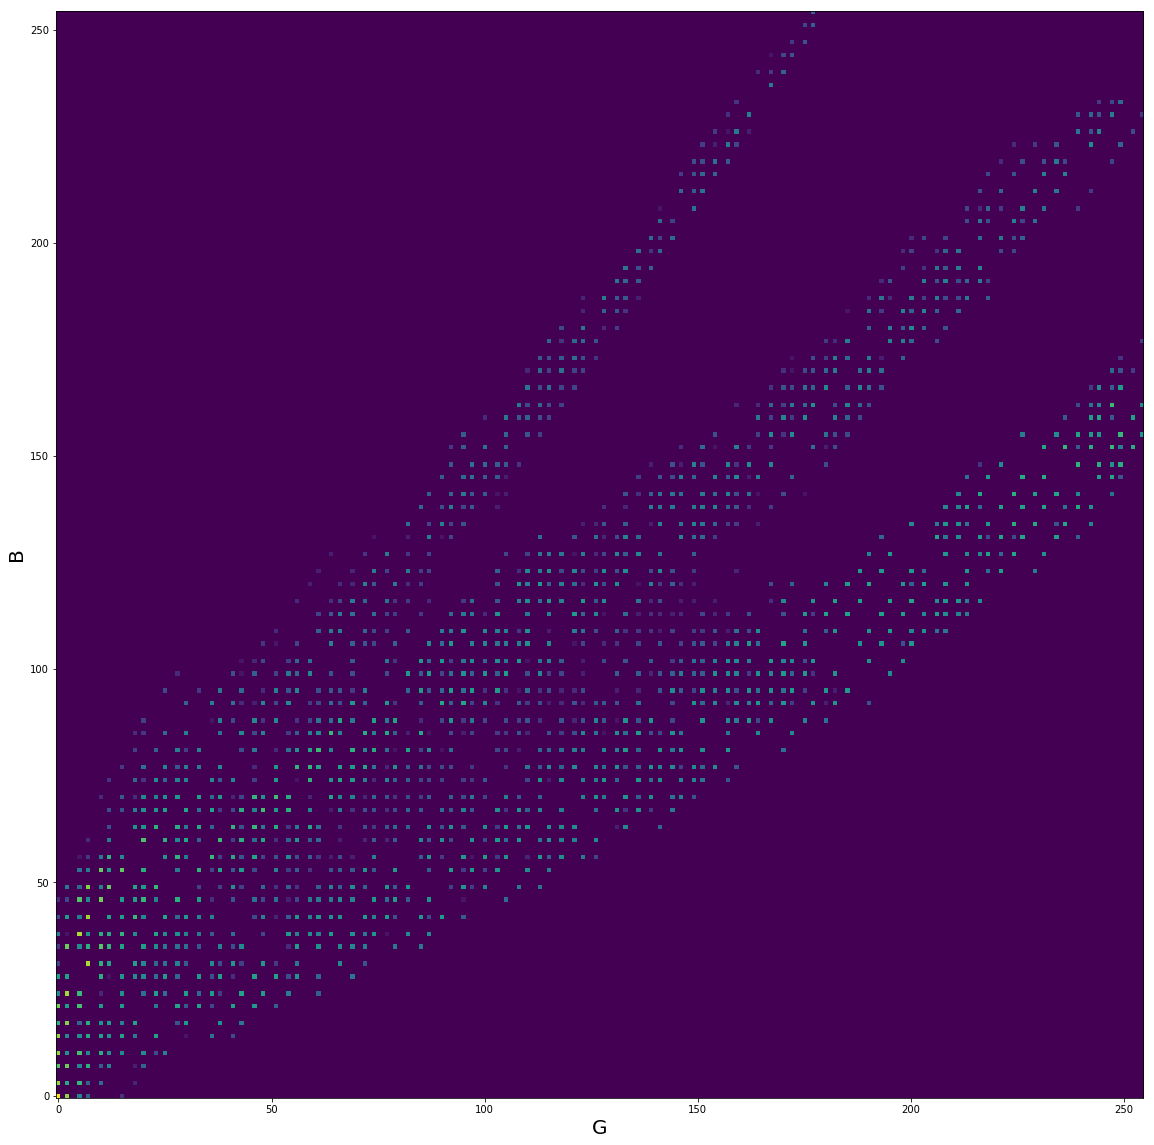

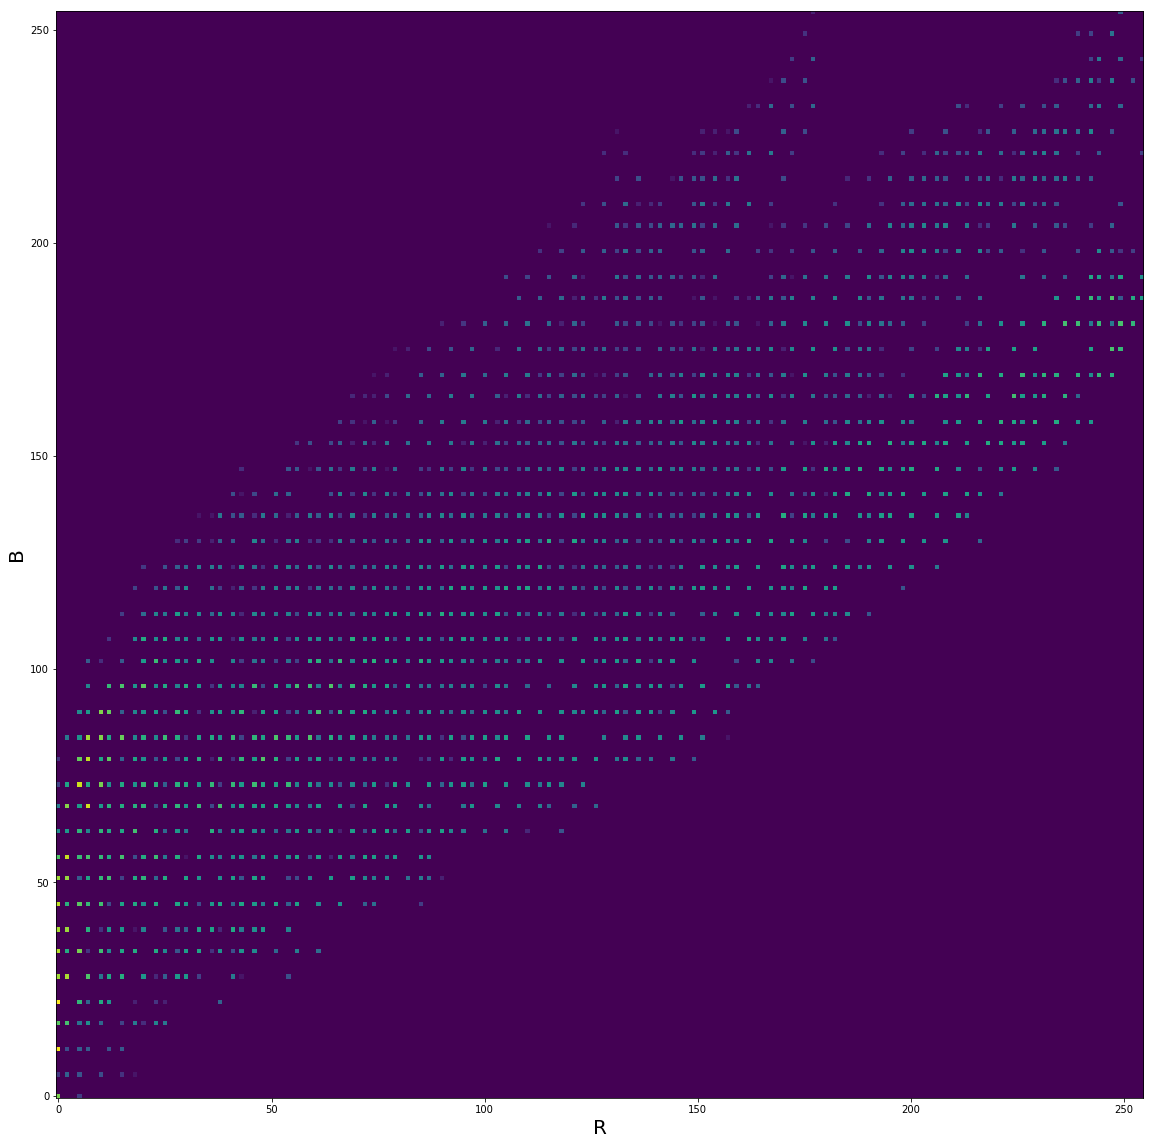

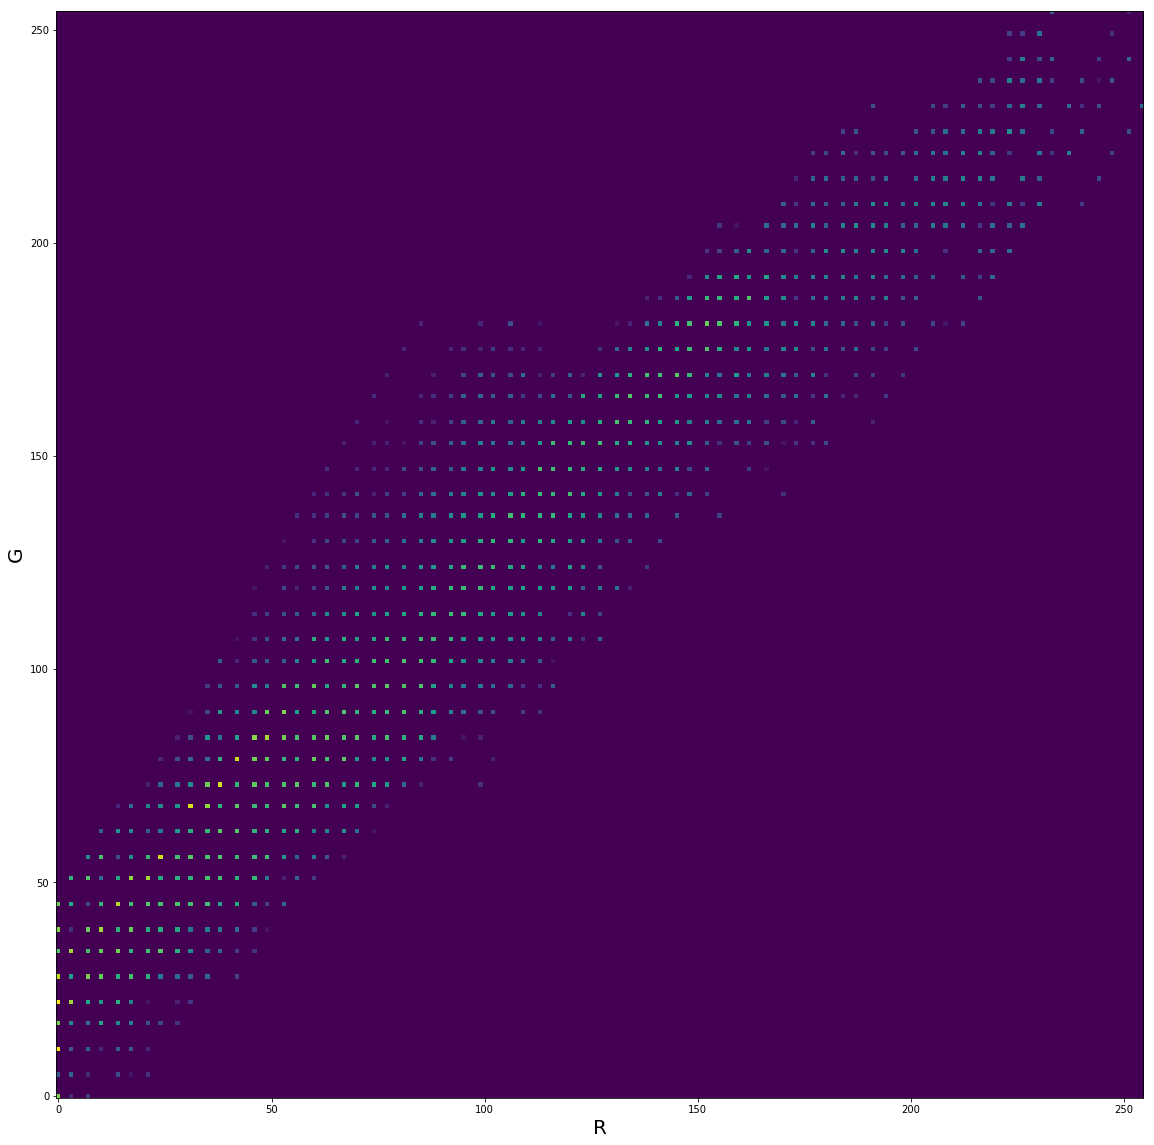

In [96]:
# Plot RGB Histogram
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs = xs,
    ys = ys,
    zs = zs,
    s = s,
    c = c
)
ax.set_xlabel('R', fontsize=20)
ax.set_ylabel('G', fontsize=20)
ax.set_zlabel('B', fontsize=20)
fig.savefig('hist_rgb.png', dpi = 100)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.imshow(np.log(gb+1))
ax.set_xlabel('G', fontsize=20)
ax.set_ylabel('B', fontsize=20)
ax.invert_yaxis()
fig.savefig('hist_gb.png', dpi = 100)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.imshow(np.log(rb+1))
ax.set_xlabel('R', fontsize=20)
ax.set_ylabel('B', fontsize=20)
ax.invert_yaxis()
fig.savefig('hist_rb.png', dpi = 100)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.imshow(np.log(rg+1))
ax.set_xlabel('R', fontsize=20)
ax.set_ylabel('G', fontsize=20)
ax.invert_yaxis()
fig.savefig('hist_rg.png', dpi = 100)
#ax.scatter()

#plt.show()

#os.remove('plot.png')

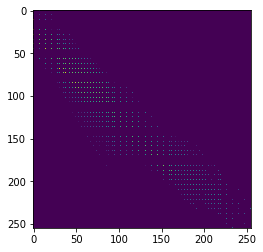

In [81]:

#gb = np.sum(H, axis=0)
#gb.shape
#plt.hist2d()
plt.show()

In [45]:
np.log(s).mean()

3.864769626475305

In [ ]:
fig = plt.figure(figsize=(20, 20))
        ax = fig.add_subplot(111)
        _ = ax.imshow(np.log(gb+1))
        ax.set_xlabel('G', fontsize=20)
        ax.set_ylabel('B', fontsize=20)
        ax.invert_yaxis()
        fig.savefig('hist_gb.png', dpi = 50)
        vid_gb_hist.write(cv2.imread('hist_gb.png').astype('uint8'))
        #os.remove('hist_gb.png')
        plt.close('all')